In [1]:
# import importlib
# importlib.reload(cluster_util)
# import cluster_util

In [2]:
import os
import sys

sys.path.insert(1, os.path.realpath(os.path.pardir))

# Notebook error analysis 

## Evaluate ml linker

In [3]:
import pandas as pd
import config

df_err_k = pd.read_excel(config.path_kaggle_error_process.joinpath('nberror_k_eid_p.xlsx'))
df_err_g = pd.read_excel(config.path_github_error_process.joinpath('nberror_g_all_eid_p.xlsx'))

df_err_k = df_err_k[df_err_k.is_MLnb&df_err_k.is_relevant&df_err_k.if_ast==1.0]
df_err_g = df_err_g[df_err_g.is_MLnb&df_err_g.is_relevant&df_err_g.if_ast==1.0]

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [4]:
print(df_err_k.fname.nunique())
print(df_err_g.fname.nunique())

2706
62265


In [18]:
# sample on fname/notebooks

import numpy as np

n = 30
k_sampled_fname = np.random.choice(df_err_k.fname.unique(), n, replace=False)
print(len(np.unique(k_sampled_fname)))

g_sampled_fname = np.random.choice(df_err_g.fname.unique(), n, replace=False)
print(len(np.unique(g_sampled_fname)))

30
30


In [36]:
# then further sample on eid/1 error per notebook

k_sampled_fname_eid = (df_err_k[df_err_k.fname.isin(k_sampled_fname)]).groupby('fname').apply(
    pd.DataFrame.sample, 
    n=1,
    include_groups=True
).reset_index(level=0, drop=True).sort_index()

g_sampled_fname_eid = (df_err_g[df_err_g.fname.isin(g_sampled_fname)]).groupby('fname').apply(
    pd.DataFrame.sample, 
    n=1,
    include_groups=True
).reset_index(level=0, drop=True).sort_index()

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_3196\889860243.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  k_sampled_fname_eid = (df_err_k[df_err_k.fname.isin(k_sampled_fname)]).groupby('fname').apply(
C:\Users\yirwa29\AppData\Local\Temp\ipykernel_3196\889860243.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_sampled_fname_eid = (df_err_g[df_err_g.fname.isin(g_sampled_fname)]).groupby('fname').a

In [43]:
k_sampled_fname_eid.to_excel(config.path_kaggle_error_process.joinpath("nberror_k_eid_p_mllinker_validation_sample0.xlsx"),
                             index=False, engine='xlsxwriter')
g_sampled_fname_eid.to_excel(config.path_github_error_process.joinpath("nberror_g_all_eid_p_mllinker_validation_sample0.xlsx"),
                             index=False, engine='xlsxwriter')

## check manual labels with the linker

In [5]:
import pandas as pd
import config

k_sampled_fname_eid = pd.read_excel(config.path_kaggle_error_process.joinpath('nberror_k_eid_p_mllinker_validation_sample0.xlsx'))
g_sampled_fname_eid = pd.read_excel(config.path_github_error_process.joinpath('nberror_g_all_eid_p_mllinker_validation_sample0.xlsx'))

In [6]:
# temp fix (changed if_ast to the ones using ast module of py3)
g_sampled_fname_eid = g_sampled_fname_eid.drop(["if_ast"], axis=1)
g_sampled_fname_eid = pd.merge(g_sampled_fname_eid, df_err_g[["eid", "if_ast"]], on="eid", how="left")
g_sampled_fname_eid = g_sampled_fname_eid[g_sampled_fname_eid.if_ast==1]

In [7]:
# join the two datasets
k_sampled_fname_eid.loc[:,"nb_source"] = config.NB_SOURCE["kaggle"]
g_sampled_fname_eid.loc[:,"nb_source"] = config.NB_SOURCE["github"]
df_sampled = pd.concat([k_sampled_fname_eid, g_sampled_fname_eid], ignore_index=True, sort=False)
len(df_sampled) 

58

In [8]:
import util

path_exp_libs = config.path_default.joinpath('links_exceptions_to_libraries.jsonl')
# res_exp_mllib = util.get_exp_mllib(path_exp_libs, df_sampled)
# df_exp_mllib = pd.DataFrame(res_exp_mllib.items(), columns=["eid", "exp_mllib"])
# df_sampled_merged = pd.merge(df_sampled, df_exp_mllib, on="eid", how="left")

In [9]:
import json
# "empty" which means found eid but not mlbug
# use this to check if there is no eid found in the linker (which will be None)
def get_exp_mllib(path_exp_libs, df_err):
    res = {eid:None for eid in df_err.eid}
    with open(path_exp_libs, "r", encoding="utf-8") as output_file:
        data = output_file.readlines()
        
    for line in data:
        j_data = json.loads(line)
        ml_links = j_data["exc_to_lib_links"]
        if len(ml_links) > 0:
            for ml_link in ml_links:
                eid = ml_link["exception_id:"]
                if eid in res:
                    if len(ml_link["libraries"]) > 0:
                        res[eid] = ml_link["libraries"]
                    else:
                        res[eid] = "empty"
#                 else:
#                     print("Error id not exist in error dataset:", Path(j_data["notebook"]).name, eid)
    return res
res_exp_mllib = get_exp_mllib(path_exp_libs, df_sampled)
df_exp_mllib = pd.DataFrame(res_exp_mllib.items(), columns=["eid", "exp_mllib"])
df_sampled_merged = pd.merge(df_sampled, df_exp_mllib, on="eid", how="left")

In [10]:
assert(sum(df_exp_mllib.exp_mllib.isnull())==0)

In [11]:
df_sampled_merged.loc[df_sampled_merged.exp_mllib=="empty","exp_mllib"]=None
sum(df_sampled_merged.exp_mllib.isnull())

27

In [12]:
df_sampled_merged["is_Mlbug_algorithm"]=(~df_sampled_merged.exp_mllib.isnull()).astype(int)

Statistics for kaggle


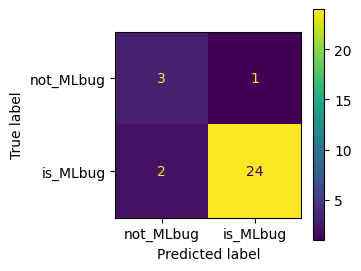

F1 score is: 0.9411764705882353

Statistics for github


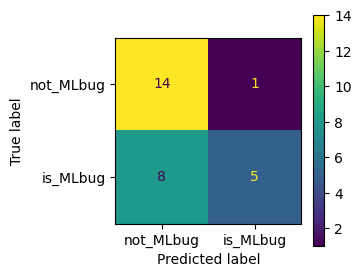

F1 score is: 0.5263157894736842



In [18]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def print_statistics(df_sampled_merged, source="kaggle"):
    df_sampled_source = df_sampled_merged[df_sampled_merged.nb_source == config.NB_SOURCE[source]]
    print("Statistics for {}".format(source))
#     print("Positives {}\nNegatives: {}".format(
#         len(df_sampled_source[(df_sampled_source.is_Mlbug_manual==1)]),
#         len(df_sampled_source[(df_sampled_source.is_Mlbug_manual==0)])))
#     print("True positives {}\nFalse Positives: {}\nTrue Negatives: {}\nFalse Negatives: {}".format(
#         len(df_sampled_source[(~df_sampled_source.exp_mllib.isnull())&(df_sampled_source.is_Mlbug_manual==1)]),
#         len(df_sampled_source[(~df_sampled_source.exp_mllib.isnull())&(df_sampled_source.is_Mlbug_manual==0)]),
#         len(df_sampled_source[df_sampled_source.exp_mllib.isnull()&(df_sampled_source.is_Mlbug_manual==0)]),
#         len(df_sampled_source[df_sampled_source.exp_mllib.isnull()&(df_sampled_source.is_Mlbug_manual==1)])))
    cm = confusion_matrix(df_sampled_source.is_Mlbug_manual, ~df_sampled_source.exp_mllib.isnull())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_MLbug", "is_MLbug"])
    fig, ax = plt.subplots(figsize=(3,3))
    disp.plot(ax=ax)
    plt.show()
    print("F1 score is: {}\n".format(f1_score(df_sampled_source.is_Mlbug_manual, ~df_sampled_source.exp_mllib.isnull())))
print_statistics(df_sampled_merged, source="kaggle")
print_statistics(df_sampled_merged, source="github")

In [25]:
#p11 (expected proportion of true positive = n11/n)
print(24/30)
#p00 (expected proportion of true negative n00/n); is not TNR = TN/(TN+FP)
print(3/30)
#p01 (expected proportion of false positive n01/n
print(1/30)
# ---sample size = 53 for kagle

0.8
0.1
0.03333333333333333


In [26]:
#p11 (expected proportion of true positive = n11/n)
print(5/28)
#p00 (expected proportion of true negative n00/n); is not TNR = TN/(TN+FP)
print(14/28)
#p01 (expected proportion of false positive n01/n
print(1/28)
# ---sample size = 832 for github

0.16666666666666666
0.5333333333333333
0.03333333333333333


In [56]:
df_sampled_merged.to_excel(config.path_github_error_process.joinpath("tmp.xlsx"), index=False, engine='xlsxwriter')